# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

You can use ** Keras ** to implement your model. Read more at [keras.io](https://keras.io/).

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0)). You are not expected to model your architecture precisely using this model nor get the same performance levels, but this is more to show an exampe of an approach used to solve this particular problem. We encourage you to try out different architectures for yourself and see what works best for you. Here is a useful [forum post](https://discussions.udacity.com/t/goodfellow-et-al-2013-architecture/202363) discussing the architecture as described in the paper and here is [another one](https://discussions.udacity.com/t/what-loss-function-to-use-for-multi-digit-svhn-training/176897) discussing the loss function.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
import numpy as np
#import tensorflow
#import theano if you want to change backend
import keras
import idx2numpy
import os

Using TensorFlow backend.


In [2]:
keras.backend.image_dim_ordering()

'tf'

For 2D data (e.g. image), "tf" assumes (rows, cols, channels) while "th" assumes (channels, rows, cols).
For 3D data, "tf" assumes (conv_dim1, conv_dim2, conv_dim3, channels) while "th" assumes  (channels, conv_dim1, conv_dim2, conv_dim3).

In [5]:
#to find where to change backend for keras: "theano" or "tensorflow" in json file
#print(os.path.expanduser('~'))

In [3]:
print (np.__version__)
print (keras.__version__)

1.11.3
1.2.1


In [4]:
#import all the pieces of the neural network
from keras.models import Sequential, Model#the model
from keras.layers import Dense, Dropout, Activation, Flatten, Input #fully connected layers
from keras.layers import Convolution2D, MaxPooling2D #the convnet
from keras.utils import np_utils #extra tools
import idx2numpy # used to concatenate MNIST dataset so that it has 5 digits

In [5]:
np.random.seed(123)  # for reproducibility

In [6]:
# read data and convert idx file to numpy array
ndarr = idx2numpy.convert_from_file('train-images-idx3-ubyte')
labels_raw = idx2numpy.convert_from_file('train-labels-idx1-ubyte')
dataset_size = ndarr.shape[0]/5
image_height = 28
image_width = (28*5) # five images long


def createSequences():
    dataset = np.ndarray(shape=(dataset_size, image_height, image_width),
                         dtype=np.float32)

    data_labels = []

    i = 0
    w = 0
    while i < dataset_size:
        temp = np.hstack(
            [ndarr[w], ndarr[w + 1], ndarr[w + 2], ndarr[w + 3], ndarr[w + 4]])
        dataset[i, :, :] = temp
        temp_str = (labels_raw[w], labels_raw[
                    w + 1], labels_raw[w + 2], labels_raw[w + 3], labels_raw[w + 4])
        data_labels.append(temp_str)
        w += 5
        i += 1

    np.array(data_labels)

    return dataset, data_labels


dataset, data_labels = createSequences()

/Users/juliadills/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


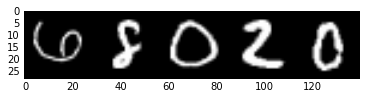

Label : (6, 8, 0, 2, 0)


In [7]:
import random
import matplotlib.pyplot as plt
%matplotlib inline
def displaySequence(n):
    fig=plt.figure()
    plt.imshow(dataset[n], cmap='gray')
    plt.show()
    print ('Label : {}'.format(data_labels[n]))
    
#display random sample to check if data is ok after creating sequences
displaySequence(random.randint(0, dataset_size))

In [8]:
dataset=dataset[:,np.newaxis,:,:] #this may not be necessary
#print a few things to make sure it looks good
print(dataset[0].shape)
print(dataset.shape)
print(len(data_labels))
print(data_labels[0])

(1, 28, 140)
(12000, 1, 28, 140)
12000
(5, 0, 4, 1, 9)


In [9]:
from sklearn.cross_validation import train_test_split
y = data_labels
X = dataset

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

/Users/juliadills/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
#lst=[[1,2,3],[11,12,13],[21,22,23]]
train_array= np.array(y_train)
test_array= np.array(y_test)
#unlike the traditional MNIST tutorials, we need to predict the concatenated image of 5 different numbers
#so I'm using numpy to create arrays for each number
#I'll then have to encode these
#train labels here
digit0=(train_array[:,0])
digit1=(train_array[:,1])
digit2=(train_array[:,2])
digit3=(train_array[:,3])
digit4=(train_array[:,4])
#do test labels as well 
digit0t=(test_array[:,0])
digit1t=(test_array[:,1])
digit2t=(test_array[:,2])
digit3t=(test_array[:,3])
digit4t=(test_array[:,4])

In [11]:
#encode train labels
tr_0 = np_utils.to_categorical(digit0, 10) #10 possible digits to encode 0-9
tr_1 = np_utils.to_categorical(digit1, 10)
tr_2 = np_utils.to_categorical(digit2, 10)
tr_3 = np_utils.to_categorical(digit3, 10)
tr_4 = np_utils.to_categorical(digit4, 10) 
#encode test labels
te_0 = np_utils.to_categorical(digit0t, 10)
te_1 = np_utils.to_categorical(digit1t, 10)
te_2 = np_utils.to_categorical(digit2t, 10)
te_3 = np_utils.to_categorical(digit3t, 10)
te_4 = np_utils.to_categorical(digit4t, 10)

In [15]:
print('X_train shape:', X_train.shape)
print('y_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(tr_3.shape, 'encoded training labels for digit 3')

X_train shape: (9600, 1, 28, 140)
y_train shape: (9600, 1, 28, 140)
9600 train samples
2400 test samples
(9600, 10) encoded training labels for digit 3


In [12]:
#data must be reshaped for tensorflow backend input
X_train = X_train.reshape(X_train.shape[0], 28, 140, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 140, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255 #normalize our data values to the range [0, 1], 255 is the max value of X_train.max()
X_test /= 255

In [45]:
from keras.callbacks import ModelCheckpoint

In [46]:
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [14]:
from keras.callbacks import History
history = History()

In [15]:
#THE MODEL#
batch_size = 128
nb_classes = 10
nb_epoch = 2

img_rows =28
img_cols=140
img_channels = 1

model_input=Input(shape=(img_rows, img_cols, img_channels))

x = Convolution2D(32, 3, 3, border_mode='same')(model_input)
x = Activation('relu')(x)
x = Convolution2D(32, 3, 3)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
conv_out = Flatten()(x)

x1 = Dense(nb_classes, activation='softmax')(conv_out)
x2 = Dense(nb_classes, activation='softmax')(conv_out)
x3 = Dense(nb_classes, activation='softmax')(conv_out)
x4 = Dense(nb_classes, activation='softmax')(conv_out)
x5 = Dense(nb_classes, activation='softmax')(conv_out)

lst = [x1, x2, x3, x4, x5]

#model = Model(input=model_input, output=lst)
model = Model(input=model_input, output=lst) #I learned you can't use a sequential model for this type of prediction

model.compile(loss='categorical_crossentropy',
optimizer='adam',
metrics=['accuracy'])

model.fit(X_train, [tr_0, tr_1, tr_2, tr_3, tr_4], batch_size=batch_size, nb_epoch=nb_epoch, callbacks=[history],verbose=1)
#I set verbose to 0 so it wouldn't print everything

Epoch 1/2
9600/9600 [==============================] - 135s - loss: 4.6192 - dense_6_loss: 0.9074 - dense_7_loss: 0.9334 - dense_8_loss: 0.9026 - dense_9_loss: 0.8835 - dense_10_loss: 0.9923 - dense_6_acc: 0.6991 - dense_7_acc: 0.6932 - dense_8_acc: 0.7086 - dense_9_acc: 0.7154 - dense_10_acc: 0.6831   
Epoch 2/2
9600/9600 [==============================] - 132s - loss: 1.6024 - dense_6_loss: 0.3048 - dense_7_loss: 0.3067 - dense_8_loss: 0.3091 - dense_9_loss: 0.3324 - dense_10_loss: 0.3495 - dense_6_acc: 0.9080 - dense_7_acc: 0.9078 - dense_8_acc: 0.9057 - dense_9_acc: 0.8979 - dense_10_acc: 0.8922   


In [16]:
#here we see the list of outputs for the pixels of each concatenated MNIST image
#five digits
model.output

[<tf.Tensor 'Softmax_5:0' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'Softmax_6:0' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'Softmax_7:0' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'Softmax_8:0' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'Softmax_9:0' shape=(?, 10) dtype=float32>]

In [134]:
#print(history.history)
#looks like history tells you same thing verbose does

In [17]:
y_val = [te_0, te_1, te_2, te_3, te_4]
score = model.evaluate(X_test, y_val, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 1.53383401394
Test accuracy: 0.347016891241


In [18]:
Y_pred = model.predict(X_test)

In [19]:
#Y_pred has 5 arrays with shape 10 each
#this is the fifth array for example
Y_pred[4][2399].shape

(10,)

In [20]:
for n in range (0,10):
    print('predicted digits:', Y_pred[0][n].argmax(), Y_pred[1][n].argmax(), Y_pred[2][n].argmax(), Y_pred[3][n].argmax(), Y_pred[4][n].argmax())
    print('actual digits:', y_test[n])
    print('---------------------------')

predicted digits: 9 6 9 5 4
actual digits: (7, 6, 9, 5, 4)
---------------------------
predicted digits: 3 8 6 2 3
actual digits: (3, 8, 6, 2, 3)
---------------------------
predicted digits: 3 0 7 4 9
actual digits: (3, 0, 7, 4, 9)
---------------------------
predicted digits: 4 8 2 1 2
actual digits: (4, 8, 2, 1, 2)
---------------------------
predicted digits: 1 7 7 1 4
actual digits: (1, 7, 7, 1, 4)
---------------------------
predicted digits: 2 2 9 8 4
actual digits: (2, 2, 9, 8, 4)
---------------------------
predicted digits: 7 5 1 7 0
actual digits: (9, 5, 3, 7, 0)
---------------------------
predicted digits: 6 8 7 9 8
actual digits: (6, 8, 7, 9, 8)
---------------------------
predicted digits: 1 0 1 7 4
actual digits: (1, 0, 1, 7, 4)
---------------------------
predicted digits: 1 1 3 3 0
actual digits: (1, 1, 3, 5, 0)
---------------------------


In [21]:
#well that is not exactly a great score, but the out of the box accuracy metric may not be the best given the 5 predictions
#as you can see from the code above, the predicted values are similar to the actual label number 
#the first example (predicted: 4 6 9 5 4; label: 7 6 9 5 4) has only one digit wrong
#idea: try using callbacks?

### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** 
First, I did an MNIST tutorial: https://elitedatascience.com/keras-tutorial-deep-learning-in-python 

Second, I researched and read the forum to figure out the best way to concatenate the MNIST images, and it looked like the package idx2numpy was the best idea.

Third, I was stumped for a few days just figuring out to input the data to the neural net.  I realized to have the model output 5 different predictions I needed the data_labels to be a list of numpy arrays of length 5. Each of the numpy arrays then had to be encoded to have 10 different classes (ex. the number 3 would not be '3' but '0010000000'.

Fourth, I also found out that a sequential model in Keras would not work either, but one can just do from keras.models import Model.

Fifth, I modeled the code in Keras off of tutorials that existed for Cifar 10, MNIST, and other image classifications. 

Sixth, I trained the model with 12 epochs, which was computatinally expensive but did not produce better results than 2 epochs.  I am unsure if finding the optimal number of epochs is essential.  I briefly tried importing and using callbacks but had some trouble as the examples are all for sequential models.



### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**
This model has the architecture [INPUT - CONV - RELU - CONV - RELU - POOL - FC]

INPUT [28x140x1] will hold the raw pixel values of the image

CONV layer -  slides a filter (kernel) over the image and computes a dot product between their weights and the target pattern (a small region they are connected to in the input volume). This may result in volume such as [28x140x32] if we decided to use 32 filters. 

RELU layer - replaces all negative pixel values in the feature map with zero. This is a non-linear function and is helpful because real world data is usually not linear. This layer leaves the size of the volume unchanged([28x140x32]).

POOL layer - will perform a downsampling operation along the spatial dimensions (width, height), resulting in volume such as [14x70x32].

The cycles of conv and relu make the neural net wider.  Multiple stacked CONV layers can develop more complex features before the pooling reduces the data.

FC (i.e. fully-connected) layer will compute the class scores, resulting in volume of size [1x1x10], where each of the 10 numbers correspond to a class score, such as among the 10 categories of MNIST (numbers 0-9).

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**  I used a package idx2numpy to concatenate the images. I did reset the axis previously so re-running the below code is necessary to view the synthetic dataset.

In [149]:
# read data and convert idx file to numpy array
ndarr = idx2numpy.convert_from_file('train-images-idx3-ubyte')
labels_raw = idx2numpy.convert_from_file('train-labels-idx1-ubyte')
dataset_size = ndarr.shape[0]/5
image_height = 28
image_width = (28*5) # five images long


def createSequences():
    dataset = np.ndarray(shape=(dataset_size, image_height, image_width),
                         dtype=np.float32)

    data_labels = []

    i = 0
    w = 0
    while i < dataset_size:
        temp = np.hstack(
            [ndarr[w], ndarr[w + 1], ndarr[w + 2], ndarr[w + 3], ndarr[w + 4]])
        dataset[i, :, :] = temp
        temp_str = (labels_raw[w], labels_raw[
                    w + 1], labels_raw[w + 2], labels_raw[w + 3], labels_raw[w + 4])
        data_labels.append(temp_str)
        w += 5
        i += 1

    np.array(data_labels)

    return dataset, data_labels


dataset, data_labels = createSequences()

/Users/juliadills/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


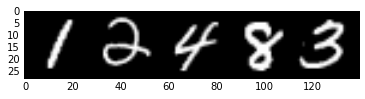

Label : (1, 2, 4, 8, 3)


In [151]:
#display random sample to check if data is ok after creating sequences
displaySequence(random.randint(0, dataset_size))

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [22]:
#load in the SVHN dataset that I have previously downloaded and pickled in similar fashion to the tensorflow tutorials
#i am using the cropped images
from six.moves import cPickle as pickle
pickle_file = 'SVHN_multi.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (29717, 32, 32, 1) (29717, 6)
Validation set (3684, 32, 32, 1) (3684, 6)
Test set (13068, 32, 32, 1) (13068, 6)


In [23]:
#10 means null (we have 0-9 plus no number bc the length is not fixed at 5 digits)
train_labels

array([[ 1,  8, 10, 10, 10, 10],
       [ 2,  7,  2, 10, 10, 10],
       [ 2,  5,  8, 10, 10, 10],
       ..., 
       [ 1,  7, 10, 10, 10, 10],
       [ 2,  2,  3, 10, 10, 10],
       [ 3,  4,  2,  5, 10, 10]])

In [24]:
#for the model, the arrays must be created and encoded as before
digit02=(train_labels[:,0])
digit12=(train_labels[:,1])
digit22=(train_labels[:,2])
digit32=(train_labels[:,3])
digit42=(train_labels[:,4])
digit52=(train_labels[:,5]) 

digit0t2=(test_labels[:,0])
digit1t2=(test_labels[:,1])
digit2t2=(test_labels[:,2])
digit3t2=(test_labels[:,3])
digit4t2=(test_labels[:,4])
digit5t2=(test_labels[:,5])

In [25]:
#encoding
tr_02 = np_utils.to_categorical(digit02, 11)#11 classes, not 10 like before
tr_12 = np_utils.to_categorical(digit12, 11)
tr_22 = np_utils.to_categorical(digit22, 11)
tr_32 = np_utils.to_categorical(digit32, 11)
tr_42 = np_utils.to_categorical(digit42, 11) 
tr_52 = np_utils.to_categorical(digit52, 11) 

te_02 = np_utils.to_categorical(digit0t2, 11)
te_12 = np_utils.to_categorical(digit1t2, 11)
te_22 = np_utils.to_categorical(digit2t2, 11)
te_32 = np_utils.to_categorical(digit3t2, 11)
te_42 = np_utils.to_categorical(digit4t2, 11) 
te_52 = np_utils.to_categorical(digit5t2, 11) 

In [26]:
batch_size2 = 128
nb_classes2 = 11 #change number of classes
nb_epoch2 = 2

img_rows2 =32 #change input size
img_cols2=32
img_channels2 = 1

model_input2=Input(shape=(img_rows2, img_cols2, img_channels2))

x2 = Convolution2D(32, 3, 3, border_mode='same')(model_input2)
x2 = Activation('relu')(x2)
x2 = Convolution2D(32, 3, 3)(x2)
x2 = Activation('relu')(x2)
x2 = MaxPooling2D(pool_size=(2, 2))(x2)
x2 = Dropout(0.25)(x2)
conv_out2 = Flatten()(x2)

x12 = Dense(nb_classes2, activation='softmax')(conv_out2)
x22 = Dense(nb_classes2, activation='softmax')(conv_out2)
x32 = Dense(nb_classes2, activation='softmax')(conv_out2)
x42 = Dense(nb_classes2, activation='softmax')(conv_out2)
x52 = Dense(nb_classes2, activation='softmax')(conv_out2)
x62 = Dense(nb_classes2, activation='softmax')(conv_out2)

lst2 = [x12, x22, x32, x42, x52, x62]

#model = Model(input=model_input, output=lst)
model2 = Model(input=model_input2, output=lst2)

model2.compile(loss='categorical_crossentropy',
optimizer='adam',
metrics=['accuracy'])

model2.fit(train_dataset,[tr_02, tr_12, tr_22, tr_32, tr_42, tr_52], batch_size=batch_size, nb_epoch=nb_epoch, verbose=1)

Epoch 1/2
29717/29717 [==============================] - 103s - loss: 4.6803 - dense_11_loss: 0.5332 - dense_12_loss: 1.2679 - dense_13_loss: 1.6583 - dense_14_loss: 0.9478 - dense_15_loss: 0.2526 - dense_16_loss: 0.0205 - dense_11_acc: 0.7959 - dense_12_acc: 0.5820 - dense_13_acc: 0.4598 - dense_14_acc: 0.7410 - dense_15_acc: 0.9519 - dense_16_acc: 0.9958   
Epoch 2/2
29717/29717 [==============================] - 118s - loss: 2.7876 - dense_11_loss: 0.2752 - dense_12_loss: 0.7238 - dense_13_loss: 1.0774 - dense_14_loss: 0.5822 - dense_15_loss: 0.1248 - dense_16_loss: 0.0043 - dense_11_acc: 0.9069 - dense_12_acc: 0.7756 - dense_13_acc: 0.6669 - dense_14_acc: 0.8317 - dense_15_acc: 0.9684 - dense_16_acc: 0.9997   


In [27]:
ypred_svhn = model2.predict(test_dataset)

In [28]:
for n in range (0,10):
    print('predicted digits:', ypred_svhn[0][n].argmax(), ypred_svhn[1][n].argmax(), ypred_svhn[2][n].argmax(), ypred_svhn[3][n].argmax(), ypred_svhn[4][n].argmax(), ypred_svhn[5][n].argmax())
    print('actual digits:', test_labels[n])
    print('---------------------------')

predicted digits: 1 5 10 10 10 10
actual digits: [ 1  5 10 10 10 10]
---------------------------
predicted digits: 2 2 0 0 10 10
actual digits: [ 3  2  1  0 10 10]
---------------------------
predicted digits: 2 6 10 10 10 10
actual digits: [ 1  6 10 10 10 10]
---------------------------
predicted digits: 1 1 10 10 10 10
actual digits: [ 1  1 10 10 10 10]
---------------------------
predicted digits: 1 1 10 10 10 10
actual digits: [ 1  9 10 10 10 10]
---------------------------
predicted digits: 1 1 10 10 10 10
actual digits: [ 1  1 10 10 10 10]
---------------------------
predicted digits: 3 1 8 3 10 10
actual digits: [ 3  1  8  3 10 10]
---------------------------
predicted digits: 2 1 8 10 10 10
actual digits: [ 2  6  5 10 10 10]
---------------------------
predicted digits: 3 1 4 4 10 10
actual digits: [ 3  1  4  4 10 10]
---------------------------
predicted digits: 2 1 6 10 10 10
actual digits: [ 2  1  6 10 10 10]
---------------------------


In [29]:
y_val2 = [te_02, te_12, te_22, te_32, te_42, te_52]
score = model2.evaluate(test_dataset, y_val2, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 2.63144206023
Test accuracy: 0.248725370052


### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:** The change I had to make was to change the model input to fit the new dataset and to add another dense layer for the extra class (the possibility that there is not a number because all of the dataset does not have exactly five digits as before).  

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:** 

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**  The accuracy metric is similar to running it on the concatenated MNIST data. However, when printed out, the predictions look ok.  I'm hoping for feedback on this logic.

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [31]:
from scipy import misc
import glob

new_images=[]

for image_path in glob.glob("new images/*.jpg"):
    image = misc.imread(image_path)
    print (image.shape)
    print (image.dtype)
    new_images.append(image)

(32, 32, 3)
uint8
(32, 32, 3)
uint8
(32, 32, 3)
uint8
(32, 32, 3)
uint8
(32, 32, 3)
uint8
(32, 32, 3)
uint8
(32, 32, 3)
uint8
(32, 32, 3)
uint8


In [32]:
len(new_images)

8

In [33]:
def displaySequence2(n):
    fig=plt.figure()
    plt.imshow(new_images[n], cmap='gray')
    plt.show()

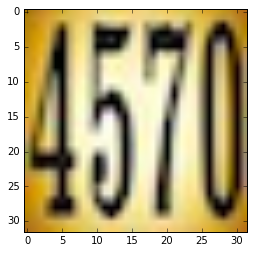

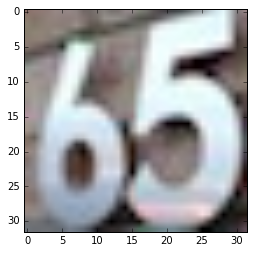

In [98]:
displaySequence2(0)
displaySequence2(1)

In [43]:
import matplotlib.image as img


new_images2=[]

for image_path in glob.glob("new images/*.jpg"):
    image = img.imread(image_path)
    print (image.shape)
    print (image.dtype)
    new_images2.append(image)


(32, 32, 3)
uint8
(32, 32, 3)
uint8
(32, 32, 3)
uint8
(32, 32, 3)
uint8
(32, 32, 3)
uint8
(32, 32, 3)
uint8
(32, 32, 3)
uint8
(32, 32, 3)
uint8


In [46]:
new_images2[0].shape

(32, 32, 3)

In [58]:
#reshape images for input into the model
reshaped=[]
for image in new_images2:
    image = image.reshape(image.shape[2],32,32,1)
    image.astype(float)
    image=image/255
    reshaped.append(image)
    


In [59]:
reshaped[0].max()

1.0

In [101]:
reshaped[0].shape

(3, 32, 32, 1)

In [89]:
new_pred = model2.predict(reshaped[0])

In [91]:
print(new_pred[0][0].argmax())
print(new_pred[1].argmax())
print(new_pred[2].argmax())
print(new_pred[3].argmax())
print(new_pred[4].argmax())
print(new_pred[5].argmax())

1
1
21
32
21
21


In [ ]:
#this prediction should equal 4570

In [96]:
new_pred2 = model2.predict(reshaped[1])

In [97]:
print(new_pred2[0].argmax())
print(new_pred2[1].argmax())
print(new_pred2[2].argmax())
print(new_pred2[3].argmax())
print(new_pred2[4].argmax())
print(new_pred2[5].argmax())

1
15
10
21
21
21


In [99]:
#this prediction should be 65

### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

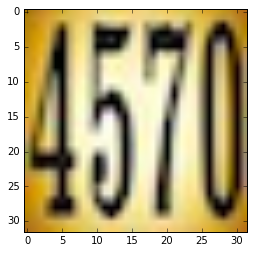

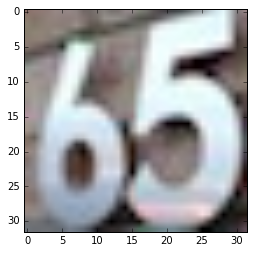

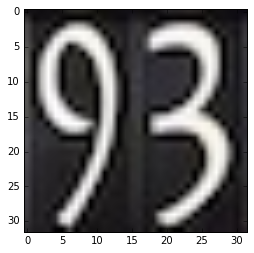

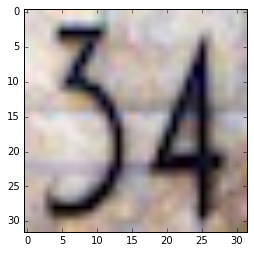

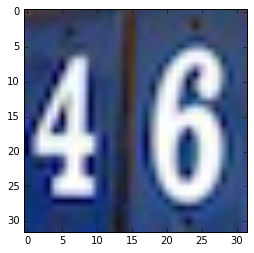

In [102]:
displaySequence2(0)
displaySequence2(1)
displaySequence2(2)
displaySequence2(3)
displaySequence2(4)


**Answer:** These five images are in color with various fonts, however they are not highly skewed.  The SVHN dataset also has many fonts and skew so I am unsure why the model is predicting so badly. 

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:** Not currently, I am hoping for some feedback to improve it or to let me know if I went wrong somewhere.

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.